## Data preperation and preprocessing

### Data source

We found a dataset on [reddit](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/)
which includes all the reddit comments categorized by month. A user uploaded the entire dataset to google's
bigquery platform, here's the [reddit](https://www.reddit.com/r/bigquery/comments/3cej2b/17_billion_reddit_comments_loaded_on_bigquery/)
thread.

### Downloading the data

We chose to use comments from may, 2015 for our project. For this we ran the following SQL query on the bigquery platform.

```SQL
select *
from `fh-bigquery.reddit_comments.2015_05`
where subreddit like 'science' or subreddit like 'politics' or subreddit like 'gaming' or subreddit like 'worldnews' or subreddit like 'CasualConversation' or subreddit like 'sports'
```

At first we downloaded all the comment made that month, but the resulting file was 5GB compressed.
Therefore, we limited the source subreddits to **r/science**, **r/politics**, **r/gaming**,
**r/worldnews**, **r/CasualConversation** and **r/sports**. This query still yielded 1.45 million
comments to work with, but was a manageable size. We exported the resulting table to a json file;
 `data_2015_05.json`.
No

In [1]:
# import statements
import pandas as pd
import pandasql as ps
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# create dataframe from json file
raw_data_df = pd.read_json(r'data_2015_05.json', orient='records', lines=True)

In [3]:
# show top 10 rows
raw_data_df.head(10)

,body,score_hidden,archived,name,author,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,author_flair_text,author_flair_css_class,distinguished
0,That wasn't just a personal belief of his. It'...,False,False,t1_cr7h0ln,tejon,0,1431494075,t5_2cneq,t3_35ql9d,t1_cr7fnj4,136,1433034878,0,0,cr7h0ln,politics,136,NaN,NaN,NaN
1,I think you're on to something there. But to b...,False,False,t1_crpxkmu,Tangpo,0,1432999141,t5_2cneq,t3_37tyhm,t1_crpw8y8,17,1433393342,0,0,crpxkmu,politics,17,NaN,NaN,NaN
2,They've also been rather clear on defining a f...,False,False,t1_cr43h2c,Qu1nlan,0,1431220695,t5_2cneq,t3_35eepj,t1_cr439ea,19,1432870611,0,0,cr43h2c,politics,19,NaN,NaN,NaN
3,God bless you.,False,False,t1_cr5rn0g,broncoz33,0,1431370502,t5_2qh03,t3_35liga,t1_cr5qa14,13,1432899458,0,0,cr5rn0g,gaming,13,NaN,NaN,NaN
4,Western corporations don't give a rats arse to...,False,False,t1_cra1d35,critfist,0,1431701414,t5_2qh13,t3_361cco,t1_cra0qd0,-4,1433079241,0,0,cra1d35,worldnews,-4,NaN,NaN,NaN
5,[deleted],False,False,t1_cqvze0l,[deleted],0,1430571181,t5_2qh13,t3_34lnbr,t1_cqvye5y,-3,1432729493,0,0,cqvze0l,worldnews,-3,NaN,NaN,NaN
6,http://en.wikipedia.org/wiki/Celebration_Cruis...,False,False,t1_crqsdm6,Atheist101,0,1433078136,t5_323oy,t3_37v2sr,t1_crqdes4,-4,1433496812,0,0,crqsdm6,CasualConversation,-4,NaN,NaN,NaN
7,"I'm not attacking them, I'm making an observat...",False,False,t1_crahjf8,utb040713,0,1431728711,t5_mouw,t3_3622fk,t1_cragizb,0,1433087005,0,0,crahjf8,science,0,NaN,NaN,NaN
8,"Well, that's a vile and disgusting thing to sa...",False,False,t1_cr4qp74,Fractal_Soul,0,1431286132,t5_2cneq,t3_35ffem,t1_cr4div8,0,1432881767,0,0,cr4qp74,politics,0,NaN,NaN,NaN
9,Are you 15? Lol,False,False,t1_crcbtar,chuchubaba,0,1431900496,t5_2qh03,t3_369dwg,t1_crc88ht,0,1433118815,0,0,crcbtar,gaming,0,NaN,NaN,NaN


In [4]:
# filter raw data
sql_query = " select body" \
            "       , name" \
            "       , link_id" \
            "       , parent_id" \
            "       , score" \
            " from raw_data_df" \
            " where length(body) < 200 and body <> '[deleted]'"
sdf = ps.sqldf(sql_query) # csak sdf lehet a neve

In [5]:
del raw_data_df

In [6]:
sdf.replace(r'https?://(www.)?[-a-zA-Z0-9@:%.+~#=]{1,256}.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9(_)@:%+.~#?&//=]*)','',regex=True, inplace = True)
sdf.replace(r'(/u/)?(r/)?(^)?(\\)?','',regex=True, inplace = True)
sdf.replace(r'(&gt;)','>',regex=True, inplace = True)
sdf.replace(r'(&lt)','<',regex=True, inplace = True)
sdf.replace(r'(&amp;)','&',regex=True, inplace = True)

In [7]:
response_df = sdf.rename(columns={'body': 'response'})

In [8]:
response_df.head(10)

,response,name,link_id,parent_id,score
0,They've also been rather clear on defining a f...,t1_cr43h2c,t3_35eepj,t1_cr439ea,19
1,God bless you.,t1_cr5rn0g,t3_35liga,t1_cr5qa14,13
2,Western corporations don't give a rats arse to...,t1_cra1d35,t3_361cco,t1_cra0qd0,-4
3,,t1_crqsdm6,t3_37v2sr,t1_crqdes4,-4
4,"Well, that's a vile and disgusting thing to sa...",t1_cr4qp74,t3_35ffem,t1_cr4div8,0
5,Are you 15? Lol,t1_crcbtar,t3_369dwg,t1_crc88ht,0
6,"Oh okay, cause a lot of people post similar ""t...",t1_crjr1yc,t3_372bqp,t1_crj8tdk,0
7,> according to analysts who monitor web chatte...,t1_cr2nszt,t3_357t9u,t3_357t9u,0
8,"Minavo Communications provides IVR solutions, ...",t1_cr5cntq,t3_35kx45,t3_35kx45,1
9,"Pfft, Convolvulaceae is where it's at. ;-)",t1_crmt7hn,t3_37gbrz,t1_crmsccb,1


In [9]:
# create query-response pairs
sql_query = " select inp.body" \
            "       , resp.response || ' <eos>'" \
            "       , '<sos> ' || resp.response" \
            " from response_df resp" \
            " left join sdf inp" \
            " on resp.parent_id = inp.name" \
            " where inp.body is not null and inp.body <> '' and resp.response <> ''"
sdf = ps.sqldf(sql_query)

In [13]:

xy_df = sdf.rename(columns={'body': 'input', "resp.response || ' <eos>'": 'output', "'<sos> ' || resp.response": 'output_input'})

In [15]:
del sdf

In [14]:
# show top 10 rows
xy_df.head(10)

,input,output,output_input
0,They've also been rather clear on defining a f...,"No, they have not. What gave you that idea? Th...","<sos> No, they have not. What gave you that id..."
1,Western corporations don't give a rats arse to...,"wow, ok have you ever heard of a thing called ...","<sos> wow, ok have you ever heard of a thing c..."
2,What was the conversation? I just killed them.,"""Something something something, then I raped t...","<sos> ""Something something something, then I r..."
3,Well it just shows us past behavior and what o...,"Guess you aren't a big believer in ""firsts""?\n...","<sos> Guess you aren't a big believer in ""firs..."
4,Solid advice to avoid a shaky end for TheEarth...,Agreed! <eos>,<sos> Agreed!
5,The whole schools discrimination provision was...,The fact my daughter is bottom of the list in ...,<sos> The fact my daughter is bottom of the li...
6,Hahaha yeah we can do that too. I just thought...,Nothing wrong with multitasking during a movie...,<sos> Nothing wrong with multitasking during a...
7,"Thank you!\n\nYeah, I like them and find them ...",Understandable. It's not a real exam if you do...,<sos> Understandable. It's not a real exam if ...
8,2 line pass.,False. But it was offside <eos>,<sos> False. But it was offside
9,Well shit... I never used boot bands to blouse...,My point exactly. <eos>,<sos> My point exactly.


In [16]:
# export to json
# 960411 sor, 5 oszlop
#response_df.to_json('filtered_data_2015_05.json', orient='records', lines=True)
# 485400 sor, 3 oszlop
xy_df.to_json('xy_data_2015_05.json', orient='records', lines=True)

In [19]:
del response_df
del xy_df
del sql_query

In [20]:
xy_data_df = pd.read_json(r'xy_data_2015_05.json', orient='records', lines=True)

In [27]:
print(xy_data_df['input'][172])
print(xy_data_df['output'][172])
print(xy_data_df['output_input'][172])

Do tell. How is it not true? 
Other than character skins, how are they not just pre set loadouts? 
you could unlock extra guys. one had a jet-pack if I remember correctly and another had invisibility.  <eos>
<sos> you could unlock extra guys. one had a jet-pack if I remember correctly and another had invisibility. 


In [22]:
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(xy_data_df['input'])
input_integer_seq = input_tokenizer.texts_to_sequences(xy_data_df['input'])

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 88304
Length of longest sentence in input: 54


In [23]:
output_tokenizer = Tokenizer(filters='')
output_tokenizer.fit_on_texts(pd.concat([xy_data_df['output'], xy_data_df['output_input']]))
output_integer_seq = output_tokenizer.texts_to_sequences(xy_data_df['output'])
output_input_integer_seq = output_tokenizer.texts_to_sequences(xy_data_df['output_input'])


word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 303385
Length of longest sentence in the output: 48


In [24]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (479901, 54)
encoder_input_sequences[172]: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0    31
   258    43     7     9    14   273   107    75   770  8538    43    15
    20    14    22  1181   622 34805]


In [28]:
print(word2idx_inputs["character"])
print(word2idx_inputs["skins"])

770
8538


In [25]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (479901, 48)
decoder_input_sequences[172]: [     2      7     91   6457   1087   2148     48     81      4 100254
     29      5    280   4103      8    256     81 100255      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]


In [31]:
print(word2idx_outputs["<eos>"])
print(word2idx_outputs["remember"])
print(word2idx_outputs["correctly"])
print(word2idx_outputs["invisibility"])

1
280
4103
58031


In [32]:
subset_dict = {str(value): 0 for key, value in input_tokenizer.word_index.items()}

input_sequences = []
for line in xy_data_df.iterrows():
    # Convert our headline into a sequence of tokens
    token_list = input_tokenizer.texts_to_sequences([line[1][0]])[0]

    for token in token_list:
        subset_dict[str(token)] += 1

    # print('input')
    # print(token_list)
    # print(tokenizer.sequences_to_texts([token_list]))
    # print()

    token_list = input_tokenizer.texts_to_sequences([line[1][1]])[0]

    # print('response')
    # print(token_list)
    # print(tokenizer.sequences_to_texts([token_list]))
    # print()

    for token in token_list:
        subset_dict[str(token)] += 1

the a to i you and is of it that in for this not are have on be but they was just like with what my so it's if


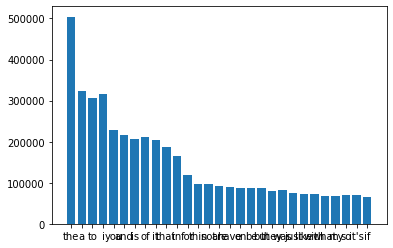

In [33]:
import matplotlib.pyplot as plt
list_c = [i for i in range(30)]
stuff = input_tokenizer.sequences_to_texts([list_c])[0]
print(stuff)

x = stuff.split()


plt.bar(x, list(subset_dict.values())[:len(x)], align = 'center')
plt.show()





